In [1]:
using Plots
using LinearAlgebra

$$
\begin{align}
    &\psi_{j-1}^{n+1} + (i\lambda - h^2 V_j - 2)\psi_j^{n+1} + \psi_{j+1}^{n+1}
    =\\
    -&\psi_{j-1}^n + (i\lambda + h^2 V_j + 2)\psi_j^n - \psi_{j+1}^n
\end{align}
$$

In [3]:
struct TridiagonalMatrix{T}
    left::Vector{T}
    mid::Vector{T}
    right::Vector{T}
end

function mat_mult(mat::TridiagonalMatrix{T}, vec::Vector{T}) where T<:Number
    len = length(vec)
    result = deepcopy(vec)
    
    result[1] = mat.mid[1] * vec[1] + mat.right[1] * vec[2]
    for j in 2:(len - 1)
        result[j] = mat.left[j-1] * vec[j-1] + mat.mid[j] * vec[j] + mat.right[j] * vec[j+1]
    end
    result[len] = mat.left[len-1] * vec[len-1] + mat.mid[len] * vec[len]
    
    return result
end

# using Gauss-Siedel
function solve_system_gs(mat::TridiagonalMatrix{T}, b::Vector{T}, x_0::Vector{T}, iterations::Int) where T<:Number
    len = length(x_0)
    result = deepcopy(x_0)
    
    for _ in 1:iterations
        result[1] = (b[1] - mat.right[1] * result[2]) / mat.mid[1]
        for j in 2:(len - 1)
            result[j] = (b[j] - mat.left[j-1] * result[j-1] - mat.right[j] * result[j+1]) / mat.mid[j]
        end
        result[len] = (b[len] - mat.left[len-1] * result[len-1]) / mat.mid[len]
    end
    
    return result
end


function modulus(wf) real.(conj(wf) .* wf) end

function rectangle(w, h, x, y) Shape(x .+ [0,w,w,0], y .+ [0,0,h,h]) end

function solve_schrodinger_cn(
        wf_0::Vector{Complex{Float64}}, potential::Vector{Float64}, 
        space_step::Float64, time_step::Float64, iterations::Int,
        gs_iterations::Int = 30
)
    n_cells::Int = length(wf_0)
    lambda = 2 * space_step ^ 2 / time_step
    
    A = TridiagonalMatrix(
        ones(Complex{Float64}, n_cells - 1),
        (@. 1im * lambda - space_step ^ 2 * potential - 2),
        ones(Complex{Float64}, n_cells - 1)
    )
    B = TridiagonalMatrix(
        -ones(Complex{Float64}, n_cells - 1),
        (@. 1im * lambda + space_step ^ 2 * potential + 2),
        -ones(Complex{Float64}, n_cells - 1)
    )
    
    wf::Matrix{Complex{Float64}} = zeros(iterations, n_cells)
    wf[1,:] = deepcopy(wf_0)
    
    for i in 1:(iterations - 1)
        
        b = mat_mult(B, wf[i,:])
        
        wf[i+1,:] = solve_system_gs(A, b, wf[i,:], gs_iterations)
    end
    
    return wf
end

solve_schrodinger_cn (generic function with 2 methods)

[ Info: Saved animation to /home/linux/projects/data-analysis/comp-phys/integration/img/cn-0.gif


Plots.AnimatedGif("/home/linux/projects/data-analysis/comp-phys/integration/img/cn-0.gif")
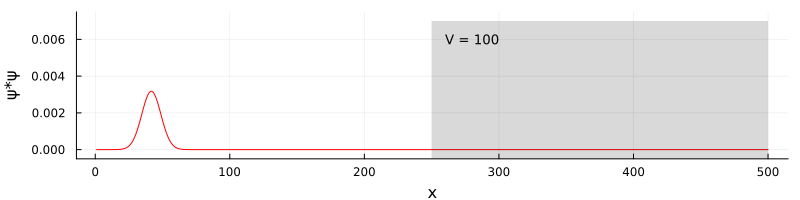

In [4]:
n_cells = 500; midpoint = Integer(n_cells / 2)
mean = 40; sigma = 10; k_0 = 1

wf_0 = [
    exp(1im * k_0 * cell) * exp(-0.5 * ((cell - mean) / sigma) ^ 2)
    for cell in 1:n_cells
]

wf2_0 = real.(conj(wf_0) .* wf_0)
wf_0 /= sum(wf2_0); wf2_0 /= sum(wf2_0)

V_height = 100

V = [zeros(midpoint); V_height * ones(n_cells - midpoint)]

wfs = solve_schrodinger_cn(
    wf_0, V, 1.0, 1.5, 200
)

ylow = -0.0005; yhigh = 0.0075


anim = Animation()
for i in 1:size(wfs)[1]
    if mod(i, 2) == 0
        plot(
            1:n_cells, modulus(wfs[i,:]),
            label = "",
            xlabel = "x",
            ylabel = "ψ*ψ",
            linecolor = :red,
            ylimits = (-0.0005, 0.0075),
            size = (800, 200),
            leftmargin = 4Plots.mm,
            bottommargin = 4Plots.mm
        )

        plot!(rectangle(n_cells - midpoint, yhigh, midpoint, ylow), 
            linewidth = 0, alpha = 0.15, color = :black,
            label = "",
            annotations = [
                (midpoint + 10, 0.006, text("V = $(V_height)", halign = :left, pointsize = 9))
            ]
        )

        frame(anim)
    end
end

gif(anim, "./img/cn-0.gif")

[ Info: Saved animation to /home/linux/projects/data-analysis/comp-phys/integration/img/cn-2.gif


Plots.AnimatedGif("/home/linux/projects/data-analysis/comp-phys/integration/img/cn-2.gif")
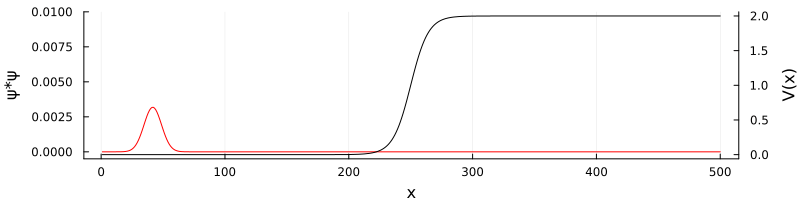

In [71]:
n_cells = 500; midpoint = Integer(n_cells / 2)
mean = 40; sigma = 10; k_0 = 1

wf_0 = [
    exp(1im * k_0 * cell) * exp(-0.5 * ((cell - mean) / sigma) ^ 2)
    for cell in 1:n_cells
]

wf2_0 = real.(conj(wf_0) .* wf_0)
wf_0 /= sum(wf2_0); wf2_0 /= sum(wf2_0)

V_height = 1

V_func(x) = V_height * (1 + tanh(0.07 * (x - 250)))

V = V_func.(1:n_cells)

wfs = solve_schrodinger_cn(
    wf_0, V, 1.0, 1.5, 200, 100
)

ylow = -0.0005
# yhigh = 0.0075
yhigh = 0.01


anim = Animation()
for i in 1:size(wfs)[1]
    if mod(i, 2) == 0
        plot(
            1:n_cells, modulus(wfs[i,:]),
            label = "",
            xlabel = "x",
            ylabel = "ψ*ψ",
            linecolor = :red,
            ylimits = (ylow, yhigh),
            size = (800, 200),
            leftmargin = 4Plots.mm,
            bottommargin = 4Plots.mm
        )
        
        plot!(twinx(),
            x -> V_func(x), 
            color = :black,
            label = "",
            ylabel = "V(x)",
            rightmargin = 4Plots.mm
        )

        frame(anim)
    end
end

gif(anim, "./img/cn-2.gif")

In [11]:
M0 = [
    [1.0 -2.0 0.0 0.0]
    [4.0 8.0 -5.0 0.0]
    [0.0 1.0 8.0 -3.0]
    [0.0 0.0 9.0 -3.0]
]
M1 = TridiagonalMatrix{Float64}(
    [4.0, 1.0, 9.0],
    [1.0, 8.0, 8.0, -3.0],
    [-2.0, -5.0, -3.0]
)

b = [1.0, 2.0, 3.0, 4.0]

x = [1.1,1.1,1.1,1.1]

sol = solve_system_gs(M1, b, x, 10)
other_sol = inv(M0) * b

[
    M0 * b,
    mat_mult(M1, b),
    mat_mult(M1, sol) .- b,
    sol,
    other_sol,
    M0 * other_sol
]

6-element Vector{Vector{Float64}}:
 [-3.0, 5.0, 14.0, 15.0]
 [-3.0, 5.0, 14.0, 15.0]
 [-4.3331863881686346, 1.019322023834754, 1.834779642902559, 0.0]
 [-1.1189737768965435, 1.1071063056360453, 0.2723266627334868, -0.5163533451328729]
 [1.5454545454545445, 0.27272727272727226, 1.2727272727272707, 2.484848484848479]
 [1.0, 2.0000000000000027, 3.000000000000001, 3.9999999999999982]

In [14]:
function ssgs(mat::Matrix{T}, b::Vector{T}, x_0::Vector{T}, iterations::Int) where T<:Number
    len = length(x_0)
    result = deepcopy(x_0)
    
    for _ in 1:iterations
        for i in 1:len
            result[i] = b[i] 
            for j in 1:len
                if j == i continue end
                
                result[i] -= mat[i,j] * result[j]
            end
            result[i] /= mat[i,i]
        end
    end
    
    return result
end


ssgs (generic function with 1 method)

In [17]:
s = ssgs(M0, b, x, 10)

[
    s,
    other_sol
]

2-element Vector{Vector{Float64}}:
 [-1.1189737768965435, 1.1071063056360453, 0.2723266627334868, -0.5163533451328729]
 [1.5454545454545445, 0.27272727272727226, 1.2727272727272707, 2.484848484848479]

In [24]:
M2 = [
    [4.0 1.0 0.0]
    [1.0 -7.0 2.0]
    [0.0 0.0 4.0]
]

b2 = [7.0, -2.0, 11.0]

x2 = zeros(3)

M2t = TridiagonalMatrix(
    [1.0, 0.0],
    [4.0, -7.0, 4.0],
    [1.0, 2.0]
)

[
    solve_system_gs(M2t, b2, x2, 10)
    ssgs(M2, b2, x2, 10)
]

6-element Vector{Float64}:
 1.4310344827591104
 1.275862068965587
 2.75
 1.4310344827591104
 1.275862068965587
 2.75

In [37]:
v = [1 + 2im, 4 - 6im]
[
    v' * v
    v[1]' * v[1] + v[2]' * v[2]
    exp(2im)
]

3-element Vector{ComplexF64}:
                57.0 + 0.0im
                57.0 + 0.0im
 -0.4161468365471424 + 0.9092974268256817im